In [35]:
from random import randint
import pandas as pd
from scipy.fft import fft
from matplotlib import pyplot as plt

import numpy as np
import scipy.signal as sg
def autocorrelation(arr:np.ndarray) -> np.ndarray:
    ret = arr-np.mean(arr)
    ret = sg.correlate(ret,ret,mode="full")[len(ret)-1:]
    # Required overlap of at least 33% of the data
    return ret[:2*len(ret)//3] / ret[0]

In [36]:
df = pd.read_csv("../Covid19Canada/timeseries_hr/cases_timeseries_hr.csv")

caseSeries = []

# province 	health_region 	date_report 	cases 	cumulative_cases
for province in df["province"].unique():
    provinceData = df[df["province"] == province]
    for hr in df["health_region"].unique():
        series = provinceData[provinceData["health_region"] == hr]
        dates = series["date_report"].values
        values = list(map(lambda x : int(x), series["cases"].values))
        if len(values) > 0:
            for i in range(len(values)-1,1,-1):
                if values[i-2] > 0 and values[i-1] == 0 and values[i] > 0:
                    values[i-1] = values[i]//2
                    values[i] = values[i]//2 + (values[i] & 1)
            for i in range(len(values)-1,2,-1):
                if values[i-3] > 0 and values[i-2] == 0 and values[i-1] == 0 and values[i] > 0:
                    values[i-2] = values[i]//3
                    values[i-1] = values[i]//3
                    values[i] = values[i]//3 + (values[i] % 3)
            for i in range(len(values)-1,0,-1):
                if values[i-1] > 20:
                    values[i] /= values[i-1]
            for i,date in enumerate(dates):
                date = tuple(map(lambda x : int(x),date.split("-")))
                dates[i] = pd.Timestamp(year=date[2],month=date[1],day=date[0])
            #print(dates,values)
            caseSeries.append(((province,hr),dates,values))

In [37]:
validPeriods = []

for line in caseSeries:
    lineData = line[2]
    periods = []
    inPeriod = False
    minI = 0
    
    # Look for consecutive dates (> 14 days) with more than 20 cases per day
    for i,inc in enumerate(lineData):
        if type(inc) is int:
            if inPeriod:
                if i - minI >= 14:
                    periods.append((minI,i))
                inPeriod = False
            else:
                minI = i
        elif not inPeriod:
            inPeriod = True
            minI = i

    # Gather period data, with location, dates,
    # relative deltas and autocorrelation of relative deltas
    for period in periods:
        newPeriod = [line[0],line[1][period[0]:period[1]]]
        tmp = np.array(lineData[period[0]:period[1]])
        newPeriod.append(tmp)
        newPeriod.append(autocorrelation(tmp))

        validPeriods.append(tuple(newPeriod))
        #print(newPeriod)
        
len(validPeriods)

18

In [38]:
minLen = 15

transformInfo = []
transforms = []

# Look for autocorrelations for periods of at least 3 weeks
for validPeriod in validPeriods:
    if len(validPeriod[3]) >= minLen:
        transforms.append(validPeriod[3][:minLen])

transforms = np.array(transforms)

len(transforms)

13

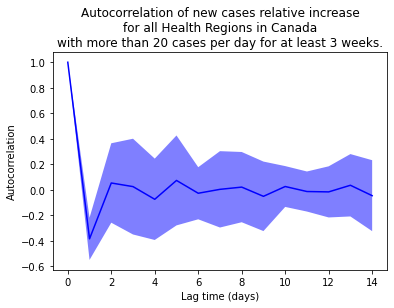

In [39]:
fig,ax = plt.subplots()

transform_means = np.mean(transforms,axis=0)
transform_sd = np.std(transforms,axis=0)

#tmp = np.abs(transforms)
#transform_abs_means = np.mean(tmp,axis=0)
#transform_abs_sd = np.std(tmp,axis=0)

ax.plot(range(15),transform_means,color="blue")
#ax.plot(range(15),transform_abs_means,color="orange")

ax.fill_between(range(15), transform_means+1.96*transform_sd, transform_means-1.96*transform_sd, facecolor='blue', alpha=0.5)
#ax.fill_between(range(15), transform_abs_means+1.96*transform_abs_sd, transform_abs_means-1.96*transform_abs_sd, facecolor='orange', alpha=0.5)

ax.set_xlabel("Lag time (days)")
ax.set_ylabel("Autocorrelation")

ax.set_title("Autocorrelation of new cases relative increase\nfor all Health Regions in Canada\nwith more than 20 cases per day for at least 3 weeks.")

plt.show()